In [1]:
import os 
import numpy as np
from leo_gym.utils.utils import seed_all

# Set experiment seed
seed = 444
seed_all(seed)


In [2]:
from perturbation_configs import * 

"""

Initialize satellite objects one represents
the ideal orbit with no perturbations and the other
the perturbed one.

At the end we will plot the effects of the perturbations 
on the final trajectory
"""

sat_real = Satellite(cfg=real_cfg)
sat_nom = Satellite(cfg=ideal_cfg)


In [3]:
from tqdm import tqdm


# Initialize lists for saving plotting data

 
grav_plot = []
irr_grav_plot = []
moon_plot = []
sun_plot = []
srp_plot = []
drag_plot = []
time_plot = []

try:
   for loops in tqdm(range(int(24*DAYS_SIMULATION*60*60/DT_SIMULATION)), desc="Processing"):
    
    # Get perturbations at current time
    grav, moon, sun, srp, drag = sat_real.dynamics1.\
        get_current_pertubration_forces(x=sat_real.rvm_eci_states[-1][:6],
                                        t=loops*60)
    
    t = loops * DT_SIMULATION 
    
    # Save perturbations
    time_plot.append(t)
    grav_plot.append(grav)
    moon_plot.append(moon)
    sun_plot.append(sun)
    srp_plot.append(srp)
    drag_plot.append(drag)

    # Apply no thrust
    sat_real.sat_propagate(np.zeros(3))
    sat_nom.sat_propagate(np.zeros(3))

except KeyboardInterrupt:
    pass


Processing: 100%|██████████| 1440/1440 [00:04<00:00, 345.03it/s]


In [4]:
# Import custom matplot style 
from leo_gym.utils.matplot_style_cfg import *


In [5]:
# Make temp directory for saving plots and data 
try:
    os.mkdir("temp")
except FileExistsError:
    pass


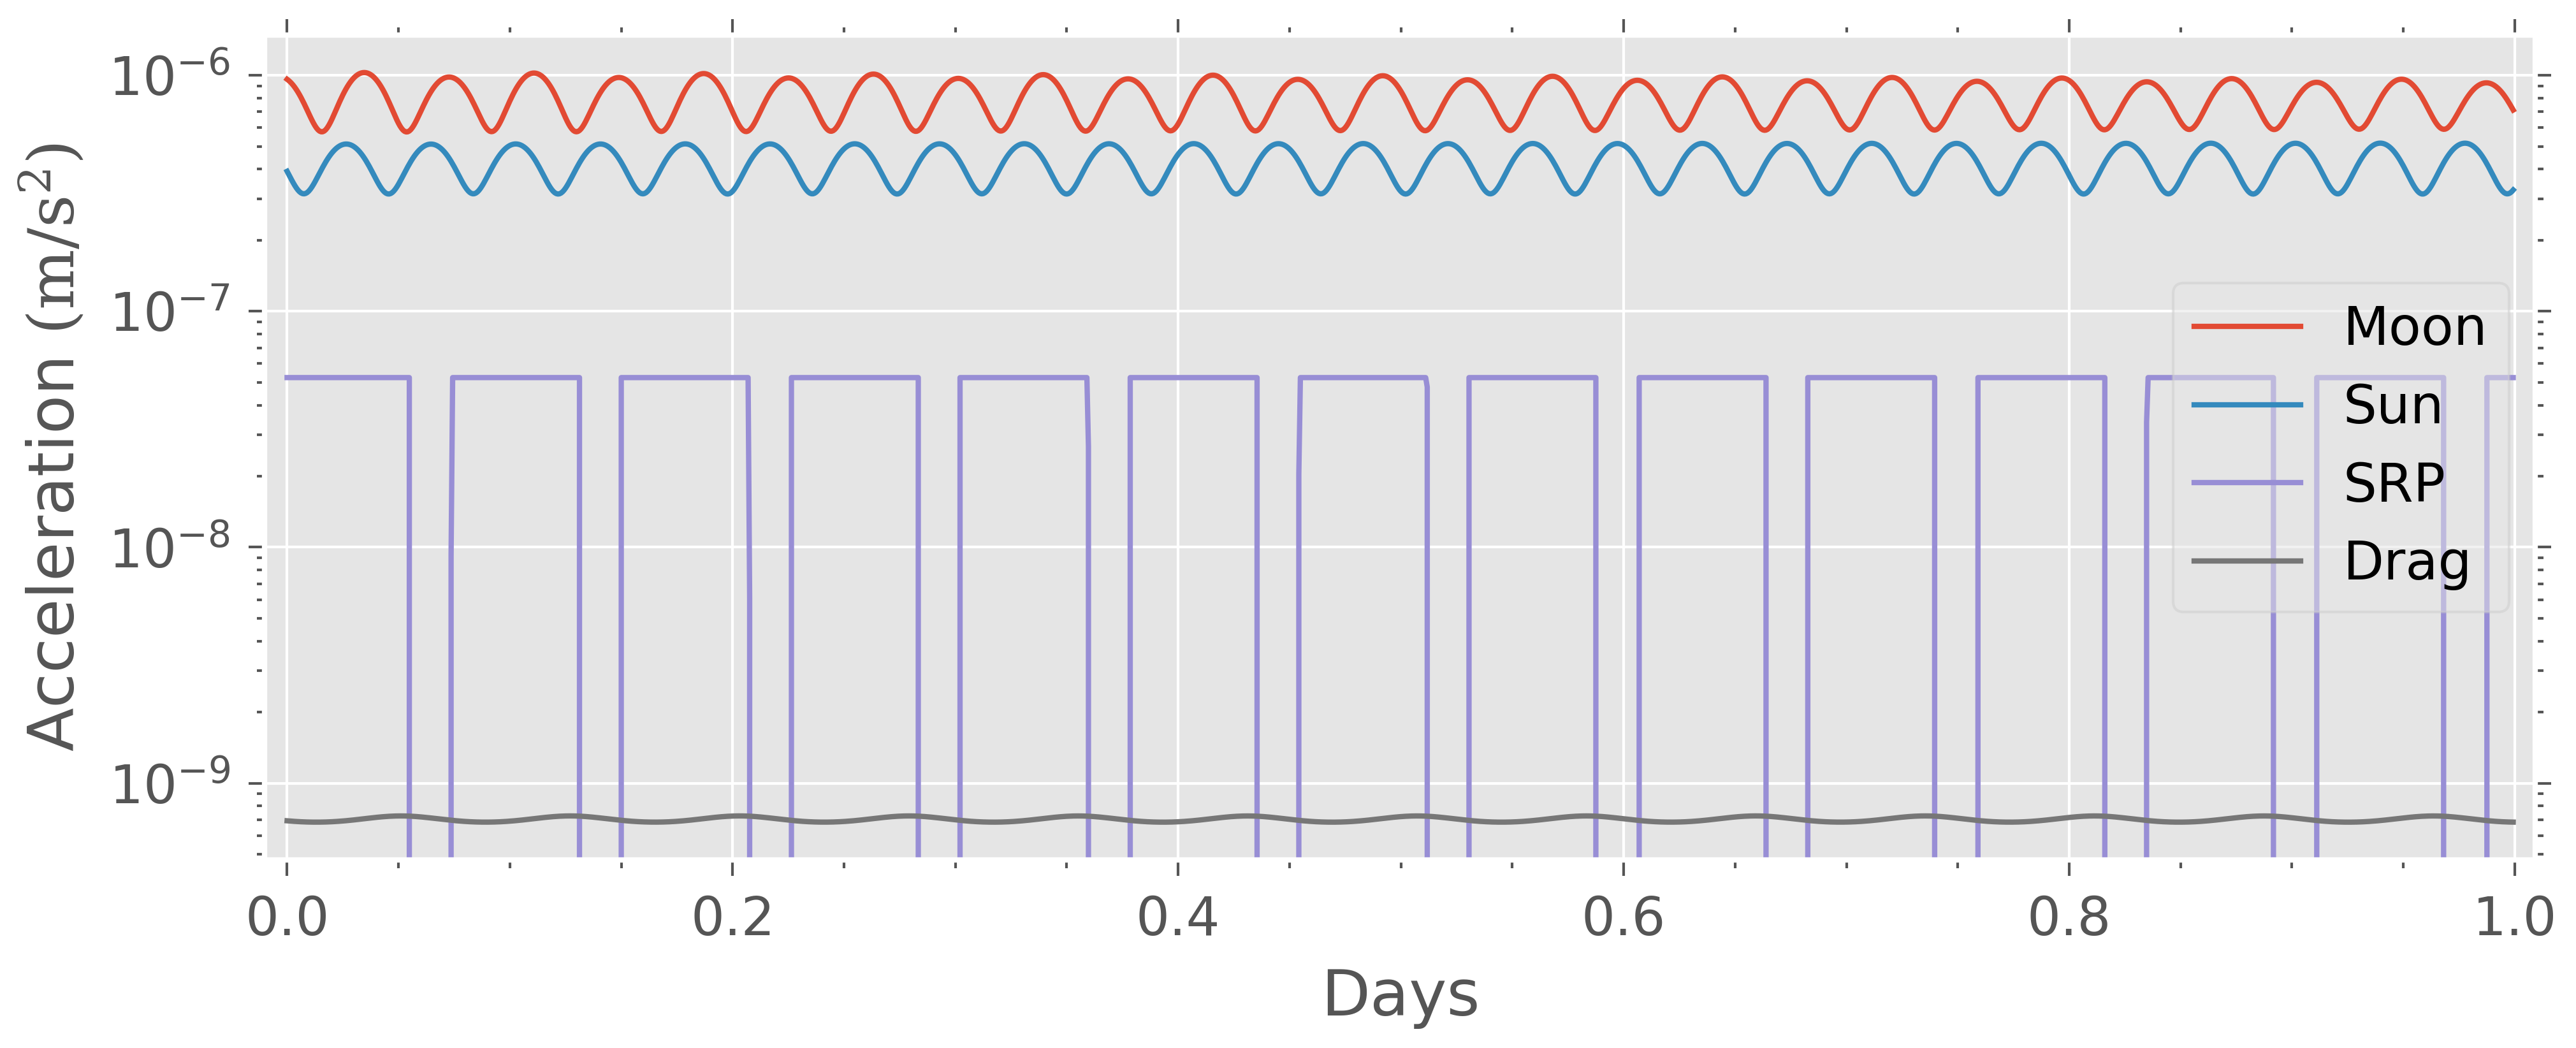

In [6]:
# Plot perturbations 

grav = np.array(grav_plot)
moon = np.array(moon_plot)
sun = np.array(sun_plot)
srp = np.array(srp_plot)
drag = np.array(drag_plot)
time_arr = np.array(time_plot)/(60*24*60)

grav_mag = np.linalg.norm(grav, axis=1)
moon_mag = np.linalg.norm(moon, axis=1)
sun_mag = np.linalg.norm(sun, axis=1)
srp_mag = np.linalg.norm(srp, axis=1)
drag_mag = np.linalg.norm(drag, axis=1)

# Plotting
plt.figure(figsize=(7, 3))
# plt.plot(time_arr, grav_mag, label='Gravitational')
plt.plot(time_arr, moon_mag, label=r'Moon')
plt.plot(time_arr, sun_mag, label=r'Sun')
plt.plot(time_arr, srp_mag, label=r'SRP')
plt.plot(time_arr, drag_mag, label=r'Drag')

plt.margins(x=0.01)

plt.yscale('log')                    
plt.xlabel('Days')
plt.ylabel(r'Acceleration $(\text{m}/\text{s}^2)$')

leg = plt.legend(frameon=True, fancybox=True)
leg.get_frame().set_alpha(0.5)

plt.grid(True)
plt.tight_layout()

plt.savefig("temp/perturbations.pdf")

plt.show()

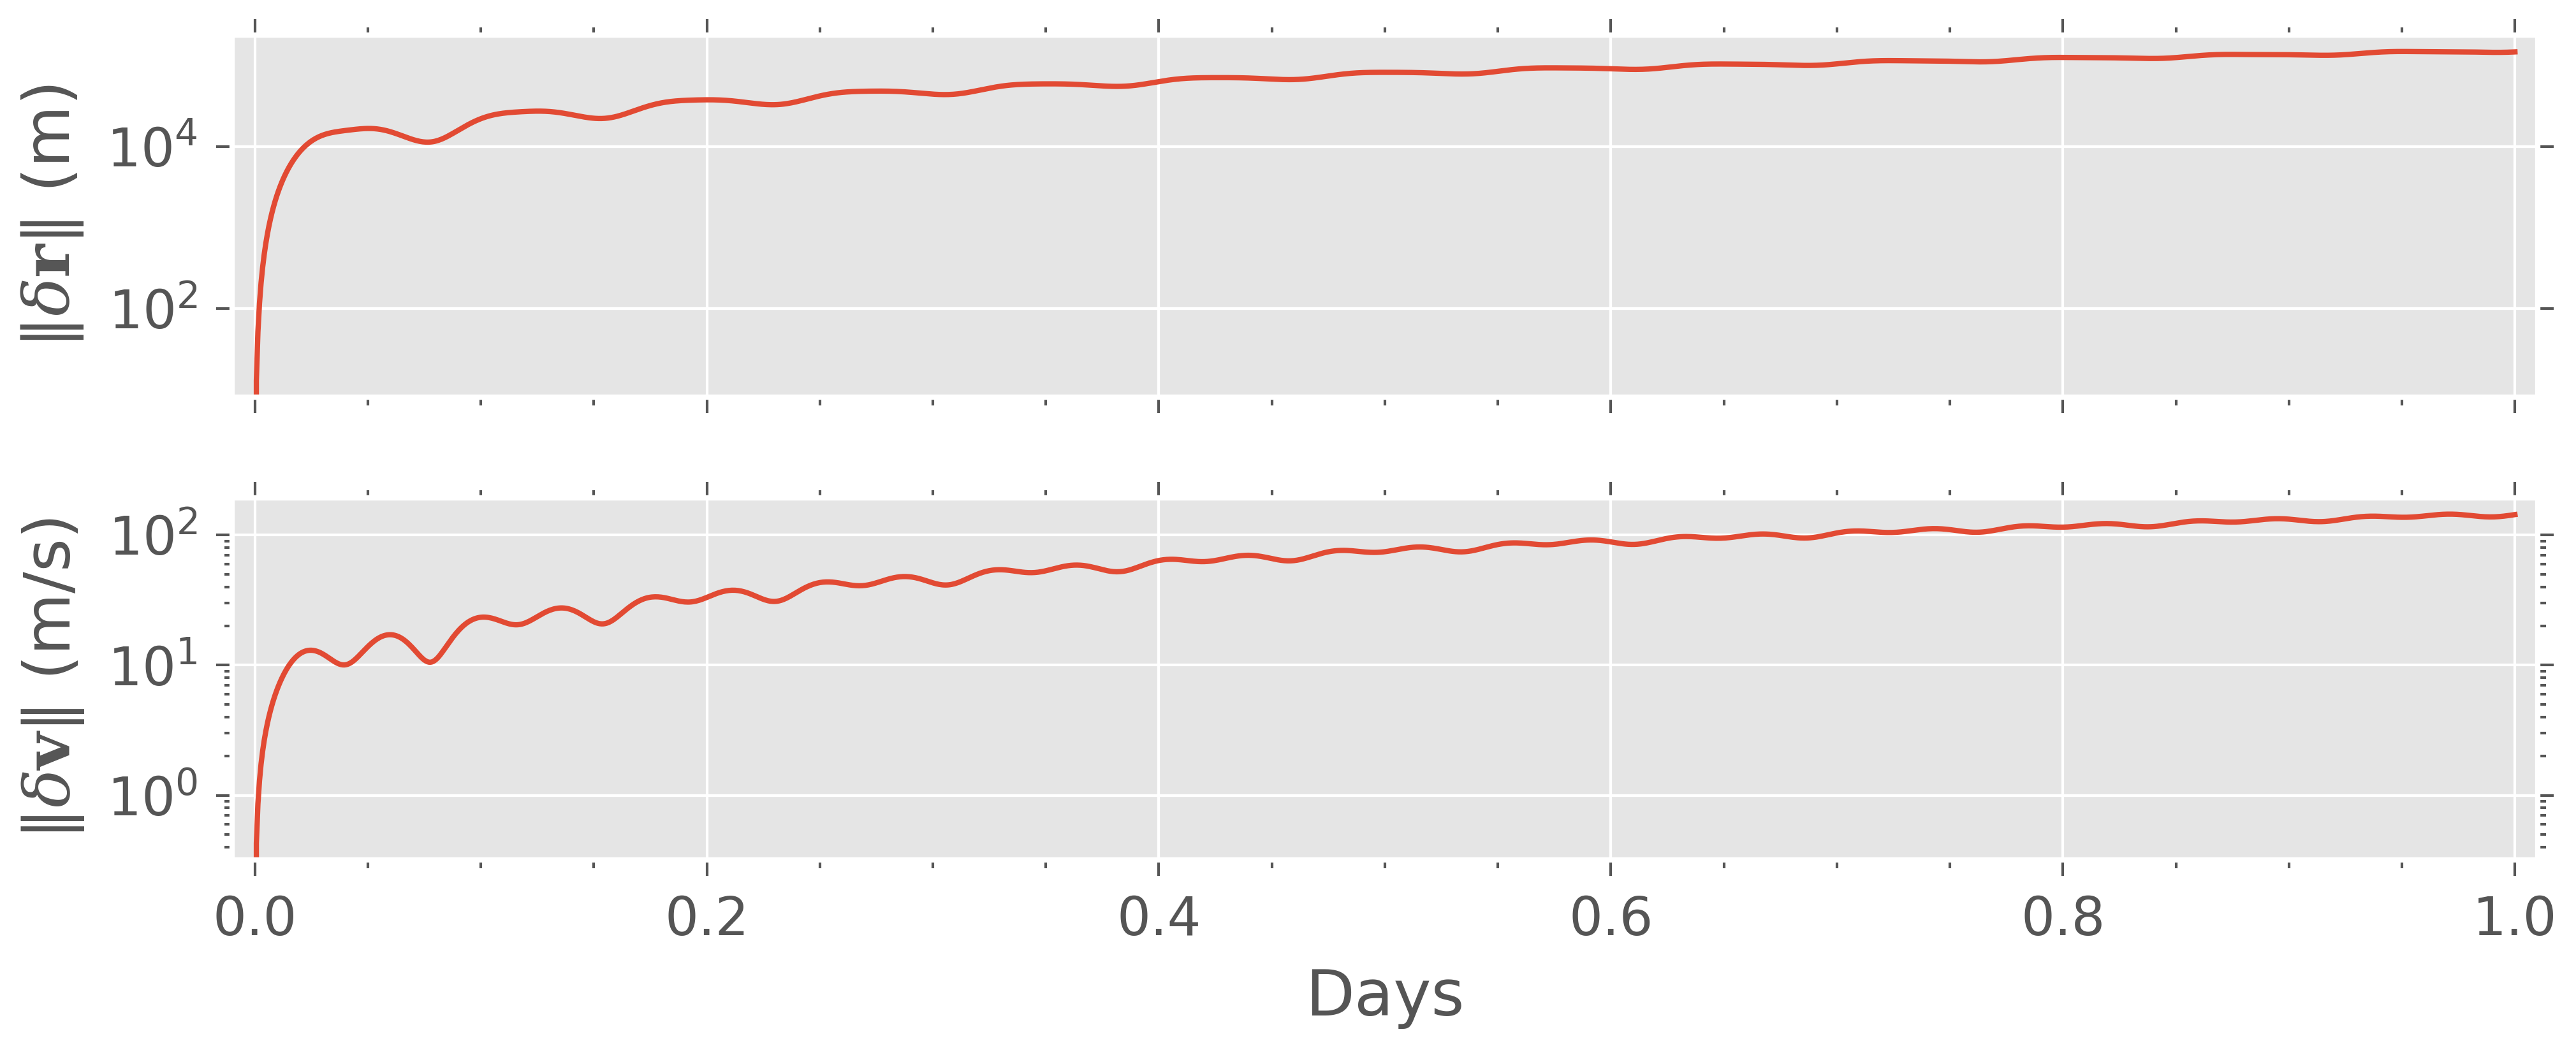

In [7]:
# Plot effects of perturbations on relative ECI position-velocity 

real_states = np.array(sat_real.rvm_eci_states)
nom_states  = np.array(sat_nom.rvm_eci_states)

pos_real = real_states[:, :3]
pos_nom  = nom_states[:,  :3]
pos_diff = np.linalg.norm(pos_real - pos_nom, axis=1)

vel_real = real_states[:, 3:6]
vel_nom  = nom_states[:,  3:6]
vel_diff = np.linalg.norm(vel_real - vel_nom, axis=1)

time = np.arange(len(pos_diff))/(60*24)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)

axes[0].plot(time, pos_diff)
axes[0].set_yscale('log')
axes[0].set_ylabel(r'$\|\delta \mathbf{r}\|$ (m)')

axes[1].plot(time, vel_diff)
axes[1].set_yscale('log')
axes[1].set_xlabel('Days')
axes[1].set_ylabel(r'$\|\delta \mathbf{v}\|$ (m/s)')

for ax in axes:
    ax.grid(True)
    ax.margins(x=0.01)

plt.tight_layout()
plt.savefig("temp/deltarv.pdf")
plt.show()
